In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from PIL import Image
from sklearn.model_selection import train_test_split
import time
import random
from datetime import datetime
import cv2

# Custom modules and packages
import params.learning
import uncertainty.functions
import uncertainty.evaluation
from utils import compute_mean_std
from dataset import TraversabilityDataset
from model import ResNet18Velocity_Regression_Alt
from train import train
from validate import validate
from test import test, test_models
from result import parameters_table, generate_log
from custom_transforms import Cutout, Shadowcasting

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.learning.LEARNING
NET_PARAMS = params.learning.NET_PARAMS

## Prepare data

#### Compute the mean and the standard deviation of the images set

In [3]:
# Load pre-computed mean and std
NORMALIZE_PARAMS = params.learning.NORMALIZE_PARAMS

normalize_params_recompute = False

if normalize_params_recompute:
    mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
    NORMALIZE_PARAMS = {"rbg": {"mean": mean[:3],
                                "std": std[:3]},
                        "depth": {"mean": mean[3],
                                  "std": std[3]},
                        "normal": {"mean": mean[4:],
                                   "std": std[4:]}}

print(NORMALIZE_PARAMS)

{'rbg': {'mean': tensor([0.4710, 0.5030, 0.4580]), 'std': tensor([0.1965, 0.1859, 0.1955])}, 'depth': {'mean': tensor([0.0855]), 'std': tensor([0.0684])}, 'normal': {'mean': tensor([0.4981, 0.5832, 0.8387]), 'std': tensor([0.1720, 0.1991, 0.1468])}}


In [4]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    
    # Perform horizontal flip of the image with a probability of 0.5
    # transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(**params.learning.JITTER_PARAMS),

    # Randomly adds a black patch to the image
    Cutout(0.5),
    
    # Randomly cast a shadow on the image
    Shadowcasting(0.5),

    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

transform_depth = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["depth"]["mean"],
            std=NORMALIZE_PARAMS["depth"]["std"]
        ),
])

transform_normal = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["normal"]["mean"],
            std=NORMALIZE_PARAMS["normal"]["std"]
        ),
])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    transform_image=train_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_test.csv",
    images_directory=params.learning.DATASET+"images_test",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Set the train dataset size
train_size = params.learning.TRAIN_SIZE/(1-params.learning.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [5]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [6]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (304 samples)
15.0 % of the data for validation (66 samples)
15.0 % of the data for testing (66 samples)


## GPU?

In [7]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [8]:
# Create a model

model = ResNet18Velocity_Regression_Alt(nb_input_channels=NET_PARAMS["nb_input_channels"],
                                    nb_input_features=NET_PARAMS["nb_input_features"],
                                    nb_classes=1).to(device=device)

In [9]:
# Create dummy tensors
images = torch.randn(32,
                     params.learning.NET_PARAMS["nb_input_channels"],
                     params.learning.IMAGE_SHAPE[0],
                     params.learning.IMAGE_SHAPE[1]).to(device=device)  # (batch, channels, height, width)
data = torch.randn(32, 1).to(device=device)  # (batch, features)

print(model(images, data).shape)

torch.Size([32])


#### Visualize the model

In [10]:
# Open TensorBoard
# tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
# images, traversal_costs, traversability_labels, linear_velocities = next(iter(train_loader))
# images = images.to(device)
# linear_velocities = linear_velocities.type(torch.float32).to(device)

# Add a dimension to the linear velocities tensor
# linear_velocities.unsqueeze_(1)

# tensorboard.add_graph(model, (images, linear_velocities))

print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
# print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

ResNet18Velocity_Regression_Alt(
  (resnet18): ResNet(
    (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [11]:
# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
# optimizer = optim.SGD([
#     {"params": base_params},
#     {"params": model.resnet18.fc.parameters(),
#      "lr": LEARNING_PARAMS["learning_rate"]*10},
# ],
#     lr=LEARNING_PARAMS["learning_rate"],
#     momentum=LEARNING_PARAMS["momentum"],
#     weight_decay=LEARNING_PARAMS["weight_decay"])

optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer, total_iters=LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the loss and accuracy values
regression_loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_regression_loss = train(model,
                                  device,
                                  train_loader,
                                  optimizer,
                                  scheduler,
                                  criterion_regression,
                                  epoch)
    
    # Validation
    val_regression_loss = validate(model,
                                   device,
                                   val_loader,
                                   criterion_regression,
                                   epoch) 
    
    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)

    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss
    
#     # Add the losses to TensorBoard
#     tensorboard.add_scalar("train_loss", train_loss, epoch)
#     tensorboard.add_scalar("val_loss", val_loss, epoch)
#     # Add the accuracies to TensorBoard
#     tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
#     tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
#     # Add the regression losses to TensorBoard
#     tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
#     tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# # Close TensorBoard
# tensorboard.close()

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  6.915386009216308
Validation regression loss:  6.143656094868978


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  5.2683683156967165
Validation regression loss:  5.528997739156087


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  3.5782259941101073
Validation regression loss:  2.202145580512782


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  2.392906868457794
Validation regression loss:  2.267965873082479


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  1.7078015685081482
Validation regression loss:  1.1574857433636982


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  1.2925461113452912
Validation regression loss:  1.7628254691759746


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  1.1093539953231812
Validation regression loss:  0.7668751080830892


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  1.0502288579940795
Validation regression loss:  1.1455896695454915


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  1.030553549528122
Validation regression loss:  1.097508688767751


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.9317472994327545
Validation regression loss:  1.0549460848172505


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.9855870425701141
Validation regression loss:  0.9020876288414001


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.9673424303531647
Validation regression loss:  0.9695463180541992


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.9616019189357757
Validation regression loss:  0.8106860121091207


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.9237265706062316
Validation regression loss:  0.8199565013249716


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.9059298038482666
Validation regression loss:  0.6351280634601911


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.9058677136898041
Validation regression loss:  1.0526707569758098


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8785003125667572
Validation regression loss:  0.7639585336049398


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8878769516944885
Validation regression loss:  0.8792311747868856


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.9101536631584167
Validation regression loss:  0.7958720127741495


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8601481199264527
Validation regression loss:  0.6878315061330795


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.894578218460083
Validation regression loss:  0.7217721740404764


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8409088969230651
Validation regression loss:  0.6487132261196772


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8562415599822998
Validation regression loss:  0.7642229199409485


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8526103079319001
Validation regression loss:  0.8676816622416178


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8176611721515655
Validation regression loss:  0.930931568145752


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8095427215099334
Validation regression loss:  1.029053012530009


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8407683312892914
Validation regression loss:  0.930228034655253


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8773455560207367
Validation regression loss:  0.6744111279646555


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8515670895576477
Validation regression loss:  0.65378870566686


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.847095650434494
Validation regression loss:  0.6620773673057556


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8580569684505462
Validation regression loss:  0.9453036586443583


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8678244292736054
Validation regression loss:  0.7560693025588989


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8168989419937134
Validation regression loss:  0.8549485206604004


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8175629019737244
Validation regression loss:  0.8580139676729838


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8153129816055298
Validation regression loss:  0.6637261807918549


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8384816646575928
Validation regression loss:  0.6419141764442126


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8392391502857208
Validation regression loss:  1.073621114095052


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8135902225971222
Validation regression loss:  0.8701892693837484


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8343564331531524
Validation regression loss:  0.6801436046759287


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8402962267398835
Validation regression loss:  0.6742679824431738


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7950313568115235
Validation regression loss:  0.8182874520619711


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8005040764808655
Validation regression loss:  0.6452347089846929


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8220421314239502
Validation regression loss:  0.8672677477200826


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8123889148235321
Validation regression loss:  0.8697826663653055


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7752814292907715
Validation regression loss:  1.0201207399368286


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7977013051509857
Validation regression loss:  0.6036913379405936


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7660246372222901
Validation regression loss:  0.6187270283699036


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7592479705810546
Validation regression loss:  0.6592609783013662


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7952174961566925
Validation regression loss:  0.7751971085866293


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7819312632083892
Validation regression loss:  0.763861080010732


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7757588505744935
Validation regression loss:  0.6845559875170389


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.8066097676753998
Validation regression loss:  0.8445454438527426


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7815228998661041
Validation regression loss:  0.7369950513044993


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7936932504177093
Validation regression loss:  0.8104739785194397


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7786726176738739
Validation regression loss:  0.7424739201863607


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7772349119186401
Validation regression loss:  0.7543194890022278


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7470921903848649
Validation regression loss:  1.0580880443255107


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.777621579170227
Validation regression loss:  0.7312130928039551


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7351670533418655
Validation regression loss:  0.7615098754564921


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7664450347423554
Validation regression loss:  1.0751880208651226


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.745243126153946
Validation regression loss:  0.6949400901794434


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7806224286556244
Validation regression loss:  0.6700411438941956


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7493776857852936
Validation regression loss:  0.6683075527350107


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7664379894733429
Validation regression loss:  0.9054547150929769


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7415358185768127
Validation regression loss:  1.3797777493794758


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7568322777748108
Validation regression loss:  0.6436142126719157


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6995022177696228
Validation regression loss:  1.1047780116399128


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7546696662902832
Validation regression loss:  0.6777830322583517


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.754018920660019
Validation regression loss:  0.5919892539580663


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7838354170322418
Validation regression loss:  0.6711723804473877


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7284724056720734
Validation regression loss:  1.156920591990153


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.760644918680191
Validation regression loss:  0.9490077098210653


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7133592903614044
Validation regression loss:  0.9466513991355896


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7332870244979859
Validation regression loss:  0.7781052589416504


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7092193931341171
Validation regression loss:  0.7706078688303629


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7212391495704651
Validation regression loss:  0.7288991212844849


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7277407467365264
Validation regression loss:  0.5477902342875799


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7324036955833435
Validation regression loss:  0.687606414159139


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7632351458072663
Validation regression loss:  0.9085986812909445


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7307225465774536
Validation regression loss:  0.6233420769373575


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6931500494480133
Validation regression loss:  0.7476913928985596


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7160995364189148
Validation regression loss:  1.041626214981079


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6707328081130981
Validation regression loss:  0.9096275369326273


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6898856163024902
Validation regression loss:  0.9402323166529337


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.7005937755107879
Validation regression loss:  1.1005606651306152


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6931384980678559
Validation regression loss:  0.6067683498064677


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.682687270641327
Validation regression loss:  0.5636828591426214


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6719128727912903
Validation regression loss:  1.1483965317408245


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6940228968858719
Validation regression loss:  0.8141684929529825


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6748800992965698
Validation regression loss:  0.6856317718823751


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6709664642810822
Validation regression loss:  0.6787675619125366


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6521553337574005
Validation regression loss:  1.1140900055567424


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6534620106220246
Validation regression loss:  0.8705311814943949


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6705758094787597
Validation regression loss:  0.5766674975554148


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.658928906917572
Validation regression loss:  0.6715784470240275


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6938077449798584
Validation regression loss:  0.6978840629259745


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6626830697059631
Validation regression loss:  0.5582005232572556


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6573739767074585
Validation regression loss:  0.994847297668457


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6511217951774597
Validation regression loss:  0.5055745268861452


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6318562805652619
Validation regression loss:  0.5857413907845815


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6552145451307296
Validation regression loss:  0.5080685516198477


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6616122335195541
Validation regression loss:  0.7569087942441305


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6341096878051757
Validation regression loss:  0.5350220501422882


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6160047203302383
Validation regression loss:  0.5561561981836954


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6352718532085418
Validation regression loss:  0.6245460510253906


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6164938598871231
Validation regression loss:  0.624825119972229


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6074312895536422
Validation regression loss:  0.727634052435557


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.613673421740532
Validation regression loss:  0.8761455217997233


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6113037794828415
Validation regression loss:  0.6537720561027527


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6020041882991791
Validation regression loss:  0.6328373352686564


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6048712968826294
Validation regression loss:  0.6056422193845113


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5937185704708099
Validation regression loss:  0.7703001697858175


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.6079704910516739
Validation regression loss:  0.7524863680203756


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5947155624628067
Validation regression loss:  0.7443869312604269


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5874530345201492
Validation regression loss:  0.45972974846760434


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5985566347837448
Validation regression loss:  0.5292937060197195


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5849316716194153
Validation regression loss:  0.5221652587254842


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.581603717803955
Validation regression loss:  0.4292000240723913


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5776895403861999
Validation regression loss:  0.8780192931493124


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5925848811864853
Validation regression loss:  0.5302316546440125


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5753651171922683
Validation regression loss:  0.7091710964838663


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5766626954078674
Validation regression loss:  0.6185751159985861


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5385873109102249
Validation regression loss:  0.5367565552393595


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5678697198629379
Validation regression loss:  0.5048409452040991


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5728555172681808
Validation regression loss:  0.462211474776268


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.563290923833847
Validation regression loss:  0.5622268517812093


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5534552276134491
Validation regression loss:  0.8706582883993784


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.555057892203331
Validation regression loss:  0.5956327716509501


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5357114970684052
Validation regression loss:  0.5280379851659139


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5309133410453797
Validation regression loss:  0.48326854904492694


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5327803492546082
Validation regression loss:  0.5149895548820496


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5476224511861801
Validation regression loss:  0.7651756008466085


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5348583936691285
Validation regression loss:  0.6226890484491984


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5409306675195694
Validation regression loss:  0.5843352874120077


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5528368026018142
Validation regression loss:  0.514102578163147


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5262081533670425
Validation regression loss:  0.7804779708385468


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5197402507066726
Validation regression loss:  0.6642353534698486


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.49451286196708677
Validation regression loss:  0.5107247233390808


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.4884695127606392
Validation regression loss:  0.5396523773670197


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5201171517372132
Validation regression loss:  0.4642339547475179


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5267287999391556
Validation regression loss:  0.5316662689050039


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5302659690380096
Validation regression loss:  0.41696517417828244


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.4863972574472427
Validation regression loss:  1.030728429555893


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.5051969707012176
Validation regression loss:  0.9410820802052816


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.4778835982084274
Validation regression loss:  1.0108530322710674


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.47768098413944243
Validation regression loss:  0.5881313780943552


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.48903008699417116
Validation regression loss:  0.48863903681437176


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.47364274859428407
Validation regression loss:  0.4583551536003749


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.4164972186088562
Validation regression loss:  0.43361859023571014


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.4947987288236618
Validation regression loss:  0.5299156308174133


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.46686303317546846
Validation regression loss:  0.40600548808773357


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.4749721050262451
Validation regression loss:  1.1572213371594746


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.4731650799512863
Validation regression loss:  0.42190926273663837


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.45442392230033873
Validation regression loss:  0.9126121898492178


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.4744202524423599
Validation regression loss:  0.4945960243542989


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.44827636778354646
Validation regression loss:  0.47465842962265015


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.423677870631218
Validation regression loss:  0.4906421701113383


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.4421687349677086
Validation regression loss:  0.5646976828575134


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.3895041808485985
Validation regression loss:  0.43048519889513653


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.39373469948768614
Validation regression loss:  0.6596359809239706


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.4196433454751968
Validation regression loss:  0.5680660804112753


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.40136093497276304
Validation regression loss:  0.48146835962931317


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.44048290997743605
Validation regression loss:  0.8208819627761841


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.3980858862400055
Validation regression loss:  0.6602988441785177


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.38997132182121275
Validation regression loss:  0.5500245193640391


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.3854722738265991
Validation regression loss:  0.9510990977287292


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.39135409891605377
Validation regression loss:  0.4774688084920247


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.4059773564338684
Validation regression loss:  0.5712409218152364


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.4189660310745239
Validation regression loss:  0.3960791490972042


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.3512782797217369
Validation regression loss:  0.4148016123411556


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.36528292298316956
Validation regression loss:  0.5035771628220876


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.3931657910346985
Validation regression loss:  0.4708162148793538


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.36781646609306334
Validation regression loss:  0.8392954667409261


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.3631333917379379
Validation regression loss:  0.4703251322110494


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.3685253694653511
Validation regression loss:  0.612889031569163


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.35409172177314757
Validation regression loss:  0.6926170786221822


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.31122763752937316
Validation regression loss:  0.48545892039934796


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.3560645043849945
Validation regression loss:  0.48880666494369507


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.32960507422685625
Validation regression loss:  0.5847137769063314


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.298072324693203
Validation regression loss:  0.6060734987258911


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.34941709488630296
Validation regression loss:  0.5830575625101725


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.3055901169776917
Validation regression loss:  0.5193710128466288


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.3076440691947937
Validation regression loss:  0.4665474047263463


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.2901878163218498
Validation regression loss:  0.7369635701179504


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.3061432659626007
Validation regression loss:  0.5892323752244314


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.33135682344436646
Validation regression loss:  1.0697391827901204


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.28913308382034303
Validation regression loss:  0.5590429703394572


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.30059234201908114
Validation regression loss:  0.9363257884979248


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.26979772597551344
Validation regression loss:  0.6070314943790436


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.2578044801950455
Validation regression loss:  0.44891693194707233


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.2876573443412781
Validation regression loss:  0.42330170919497806


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.268037948012352
Validation regression loss:  0.6064074834187826


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.2586379647254944
Validation regression loss:  0.5084847410519918


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.256247079372406
Validation regression loss:  0.5660227139790853


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.2370671160519123
Validation regression loss:  0.4270513340209921


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.2583906680345535
Validation regression loss:  0.9075058698654175


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.2611203700304031
Validation regression loss:  0.40958049272497493


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.25712218433618544
Validation regression loss:  0.540347139040629


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.24726429283618928
Validation regression loss:  0.4411000842228532


  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train regression loss:  0.23504550606012345
Validation regression loss:  0.5307221313317617


### Visualization

Text(0.5, 0, 'Epoch')

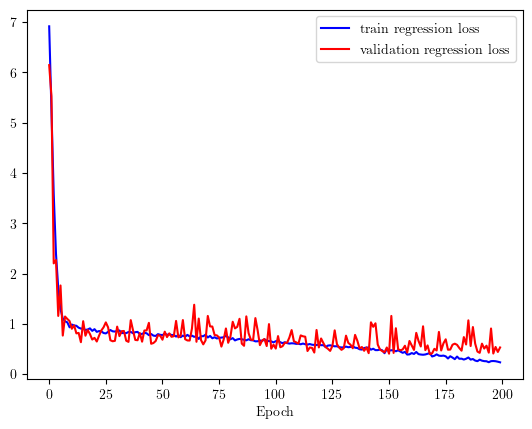

In [12]:
# Regression loss
train_regression_losses = regression_loss_values[0]
val_regression_losses = regression_loss_values[1]

plt.plot(train_regression_losses, "b", label="train regression loss")
plt.plot(val_regression_losses, "r", label="validation regression loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

#### Testing the model

In [13]:
# Set the uncertainty function
uncertainty_function = uncertainty.functions.shannon_entropy

# Test the model
test_regression_loss,\
test_regression_losses = test(model,
                              device,
                              test_loader,
                              criterion_regression,
                              uncertainty_function)

print("Regression loss: ", test_regression_loss)

Regression loss:  0.43009763956069946


#### Comparing to the worst possible loss

In [14]:
dataset_dir = "/home/gabriel/PRE/datasets/dataset_multimodal_siamese_png_quantilebinning/traversal_costs.csv"
costs_df = pd.read_csv(dataset_dir)
costs = costs_df['traversal_cost'].to_numpy()
mean_dataset_value = costs_df['traversal_cost'].mean()

print(mean_dataset_value)

mean_loss = 0.

# Add a progress bar
train_loader_pbar = tqdm(train_loader, unit="batch")

# Loop over the training batches
for images,\
    traversal_costs,\
    linear_velocities in train_loader_pbar:
    mean_tensor_value = torch.tensor(np.full(list(traversal_costs.shape), mean_dataset_value), dtype=torch.float32)

    #loss = criterion_classification(mean_tensor_label, traversability_labels)
    #
    ## Accumulate batch loss to average over the epoch
    #train_loss += loss.item()
    #
    ## Get the number of correct predictions
    #train_correct += torch.sum(
    #    torch.argmax(mean_tensor_label, dim=1) == traversability_labels
    #    ).item()
    
    # Compute and accumulate the batch loss
    mean_loss += criterion_regression(
        mean_tensor_value,
        traversal_costs).item()

# Compute the losses and accuracies
mean_loss /= len(train_loader)
    
print(mean_loss)



3.140143006727703


100%|██████████| 10/10 [00:01<00:00,  6.81batch/s]

1.8921680331230164


#### Getting some stats about the dataset

## Save model parameters

In [15]:
# Save the model parameters
# torch.save(model.state_dict(), "multimodal_velocity.params")

## Assessing the relevance of the uncertainty

In [16]:
##import uncertainty.functions
##import uncertainty.evaluation
##
### Compute the test losses after successive removal of the samples
### with the highest loss and uncertainty
##test_losses_loss, test_losses_uncertainty =\
##    uncertainty.evaluation.uncertainty_relevance(
##        model,
##        device,
##        criterion_regression,
##        uncertainty_function,
##        test,
##        test_set,
##        test_regression_loss,
##        test_regression_losses)

#### Plotting the results

In [17]:
##plt.plot(range(0, 100, 10),
##         test_losses_loss,
##         "bo--",
##         label="removing samples with highest regression loss",
##         markersize=4)
##plt.plot(range(0, 100, 10),
##         test_losses_uncertainty,
##         "ro--",
##         label="removing samples with highest uncertainty",
##         markersize=4)
##
##plt.legend(loc="upper right")
##plt.xlabel("Percentage of samples removed")
##plt.ylabel("Regression error (MSE)")

## Generate a log directory

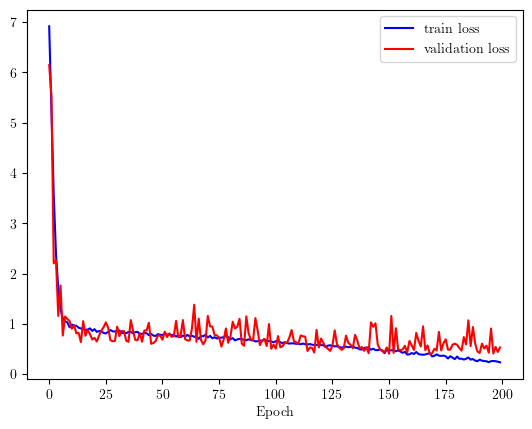

In [18]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.learning.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.learning.LOG_DIR:
    results_directory = "logs/_" +\
                        params.learning.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(results_directory=results_directory,
             test_regression_loss=test_regression_loss,
             parameters_table=params_table,
             model=model,
             regression_loss_values=regression_loss_values)

### Ensemble learning

#### Training the models

In [ ]:
# Create a list of models
nb_models = 3
some_models = [ResNet18Velocity().to(device=device) for _ in range(nb_models)]

# Loop over the models
for i in range(nb_models):
    
    print(f"Training model {i+1}/{nb_models}")
    
    # Get all the parameters excepts the weights and bias of fc layer
    base_params = [param for name, param in some_models[i].named_parameters()
                   if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

    # Define the optimizer, with a greater learning rate for the new fc layer
    optimizer = optim.SGD([
        {"params": base_params},
        {"params": some_models[i].resnet18.fc.parameters(),
         "lr": LEARNING_PARAMS["learning_rate"] * 10},
    ],
        lr=LEARNING_PARAMS["learning_rate"],
        momentum=LEARNING_PARAMS["momentum"],
        weight_decay=LEARNING_PARAMS["weight_decay"])
    
    # Loop over the epochs
    for epoch in range(LEARNING_PARAMS["nb_epochs"]):

        # Train the model
        train_loss, train_accuracy, train_regression_loss = train(some_models[i],
                                                                  device,
                                                                  train_loader,
                                                                  optimizer,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  epoch)

In [ ]:
# Create arrays to store the test losses
# test_losses_loss = np.zeros((nb_models, 10))
# test_losses_uncertainty = np.zeros((nb_models, 10))

uncertainty_function = uncertainty.functions.shannon_entropy

# Test the models
test_regression_loss, test_regression_losses, uncertainties = test_models(some_models,
                                                                          device,
                                                                          test_loader,
                                                                          criterion_classification,
                                                                          criterion_regression,
                                                                          bins_midpoints,
                                                                          uncertainty_function)
print("Test regression loss: ", test_regression_loss)

# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = \
    uncertainty.evaluation.uncertainty_relevance_models(some_models,
                                                        device,
                                                        criterion_classification,
                                                        criterion_regression,
                                                        bins_midpoints,
                                                        uncertainty_function,
                                                        test_models,
                                                        test_set,
                                                        test_regression_loss,
                                                        test_regression_losses,
                                                        uncertainties)

#### Plotting the results

In [ ]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")